# Сравнительный анализ методов сжатия изображений

В данном исследовании мы рассмотрим три фундаментальных математических подхода к обработке и сжатию изображений:

1.  **SVD (Singular Value Decomposition)** — Сингулярное разложение.
2.  **FFT (Fast Fourier Transform)** — Быстрое преобразование Фурье.
3.  **DWT (Discrete Wavelet Transform)** — Дискретное вейвлет-преобразование.

Для каждого метода мы проанализируем качество восстановления изображения при сохранении лишь малой части информации (10%, 5%, 1%, 0.2%)


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

plt.rcParams['figure.figsize'] = (14, 6)
# plt.rcParams['image.cmap'] = 'gray'


## 1. Подготовка данных 

Определим вспомогательные функции.
Мы будем использовать **Норму Фробениусова** для оценки ошибки восстановления:
$$ ||A - \tilde{A}||_F = \sqrt{\sum_{i,j} |a_{ij} - \tilde{a}_{ij}|^2} $$

Также подготовим функцию для загрузки изображений и перевода их в оттенки серого

In [51]:
import os
import skimage.io as skio 
from skimage import color
from skimage.util import img_as_ubyte

def load_image(source):
    if isinstance(source, str):
        if not os.path.exists(source):
            print(f"ОШИБКА: Файл не найден: {source}")
            return None
        
        try:
            img = skio.imread(source)
        except Exception as e:
            print(f"ОШИБКА при чтении файла {source}: {e}")
            return None
            
    else:
        print("ОШИБКА: source должен быть путем к файлу (строкой)")
        return None

    if len(img.shape) == 3:
        img = color.rgb2gray(img)
    
    # Конвертация в формат 0-255
    return img_as_ubyte(img)

def calc_frobenius_error(original, approx):
    """Считает норму Фробениуса разности матриц."""
    return np.linalg.norm(original.astype(float) - approx.astype(float), 'fro')

def plot_results(original, results, title_prefix):
    """Рисует ряд изображений: оригинал и варианты сжатия."""
    n = len(results)
    fig, axes = plt.subplots(1, n + 1, figsize=(4 * (n + 1), 4))

    # Оригинал
    axes[0].imshow(original, vmin=0, vmax=255)
    axes[0].set_title("Оригинал")
    axes[0].axis('off')

    for i, res in enumerate(results):
        ax = axes[i+1]
        ax.imshow(res['image'], vmin=0, vmax=255)
        if 'energy' in res:
            ax.set_title(f"{res['p']}% (E:{res['energy']:.1f}%, Err:{res['err']:.1f})")
        else:
            ax.set_title(f"{res['p']}% (Err: {res['err']:.1f})")
        ax.axis('off')

    plt.suptitle(title_prefix, fontsize=16)
    plt.show()

## 2. Метод сингулярного разложения (SVD)

Любое изображение $A$ размера $m \times n$ можно представить как:
$$ A = U \Sigma V^T $$
где $\Sigma$ — диагональная матрица с сингулярными числами.

**Идея сжатия:** Мы оставляем только $k$ первых (самых больших) сингулярных чисел. Это дает наилучшее низкоранговое приближение матрицы в смысле нормы Фробениусова.

Также мы построим график **Кумулятивной энергии**, который показывает, сколько информации содержат первые $k$ чисел.


In [52]:
def analyze_svd(img, percentages):
    # 1. Разложение
    U, S, Vt = np.linalg.svd(img.astype(float), full_matrices=False)

    # 2. Графики статистики
    energy = np.cumsum(S**2) / np.sum(S**2) * 100

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].semilogy(S)
    ax[0].set_title("Сингулярные числа (log scale)")
    ax[0].grid(True)

    ax[1].plot(energy)
    ax[1].set_title("Кумулятивная энергия (%)")
    ax[1].set_xlabel("Кол-во чисел (ранг)")
    ax[1].set_ylabel("% сохраненной информации")
    ax[1].grid(True)
    plt.show()

    # 3. Реконструкция
    total_modes = len(S)
    results = []

    for p in percentages:
        r = int(total_modes * (p / 100)) or 1
        # Восстановление: U_k * S_k * V_k^T
        img_approx = U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :]

        err = calc_frobenius_error(img, img_approx)
        energy_retained = energy[r-1]
        results.append({'p': p, 'image': img_approx, 'err': err, 'energy': energy_retained})

    plot_results(img, results, "SVD Reconstruction")


## 3. Двумерное преобразование Фурье (FFT)

Преобразование Фурье раскладывает изображение на сумму синусоид разных частот.
$$ F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) e^{-j2\pi(\frac{ux}{M} + \frac{vy}{N})} $$

**Идея сжатия:** Мы переводим изображение в частотную область, сортируем коэффициенты по амплитуде (модулю) и зануляем все, кроме заданного процента самых "сильных". Обычно это низкие частоты, отвечающие за общие формы.


In [53]:
def analyze_fft(img, percentages):
    # 1. Преобразование в частотную область
    f_transform = np.fft.fft2(img.astype(float))

    # Визуализация спектра (логарифмическая шкала)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1e-9)

    plt.figure(figsize=(5, 5))
    plt.imshow(magnitude_spectrum)
    plt.title("Спектр Фурье (Magnitude)")
    plt.axis('off')
    plt.show()

    # 2. Сжатие 
    # Сортируем все коэффициенты по модулю, чтобы найти порог
    f_flat = np.abs(f_transform).flatten()
    f_sorted = np.sort(f_flat)[::-1]

    results = []
    for p in percentages:
        keep_count = int(f_flat.size * (p / 100)) or 1
        threshold = f_sorted[keep_count - 1]

        # Маска: оставляем только коэффициенты > порога
        mask = np.abs(f_transform) >= threshold
        f_compressed = f_transform * mask

        # Обратное преобразование
        img_back = np.fft.ifft2(f_compressed).real

        err = calc_frobenius_error(img, img_back)
        results.append({'p': p, 'image': img_back, 'err': err})

    plot_results(img, results, "FFT Reconstruction")


## 4. Вейвлет-преобразование (Wavelet)

В отличие от Фурье, вейвлеты локализованы и в пространстве, и в частоте. Это позволяет лучше сохранять локальные особенности (например, резкие границы объектов).
Мы будем использовать вейвлет **Добеши (db4)** с уровнем разложения 4.

**Идея сжатия:** Аналогично FFT, мы выполняем разложение, получаем коэффициенты, сортируем их по модулю и оставляем только топ $N\%$.


In [54]:
def analyze_wavelet(img, percentages, wavelet='db4', levels=[4]):
    for level in levels:
        # Разложение на уровне 'level'
        coeffs = pywt.wavedec2(img.astype(float), wavelet, level=level)
        coeffs_arr, coeffs_slices = pywt.coeffs_to_array(coeffs)
        coeffs_flat_abs = np.abs(coeffs_arr).flatten()
        coeffs_sorted = np.sort(coeffs_flat_abs)[::-1]
        results = []
        for p in percentages:
            keep_count = int(coeffs_arr.size * (p / 100)) or 1
            threshold = coeffs_sorted[keep_count - 1]
            coeffs_arr_thresh = coeffs_arr * (np.abs(coeffs_arr) >= threshold)
            coeffs_thresh = pywt.array_to_coeffs(coeffs_arr_thresh, coeffs_slices, output_format='wavedec2')
            img_rec = pywt.waverec2(coeffs_thresh, wavelet)
            img_rec = img_rec[:img.shape[0], :img.shape[1]]
            err = calc_frobenius_error(img, img_rec)
            results.append({'p': p, 'image': img_rec, 'err': err})
        plot_results(img, results, f"Wavelet ({wavelet}) level {level} Reconstruction")



## 5. Запуск экспериментов


Для каждого изображения применим все три метода сжатия



==================== ПОРТРЕТ ====================


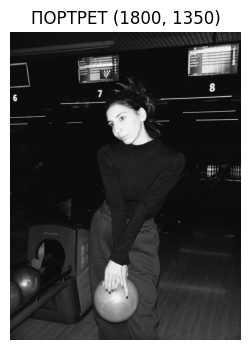

--- Method: SVD (ПОРТРЕТ) ---


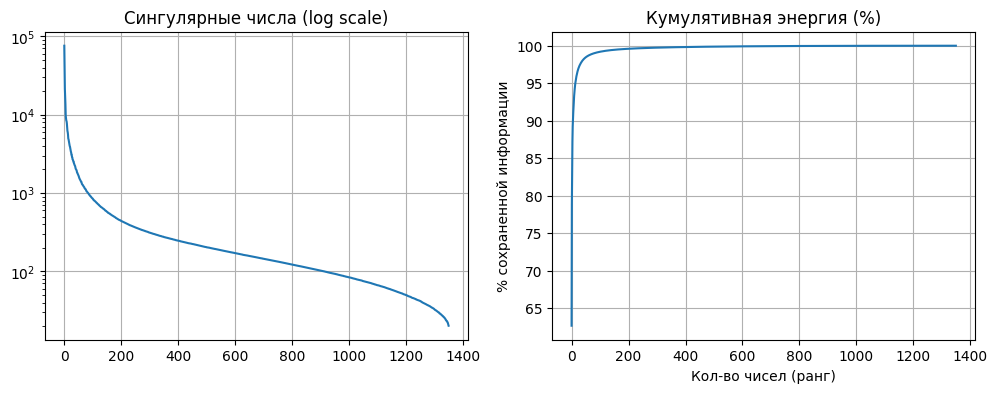

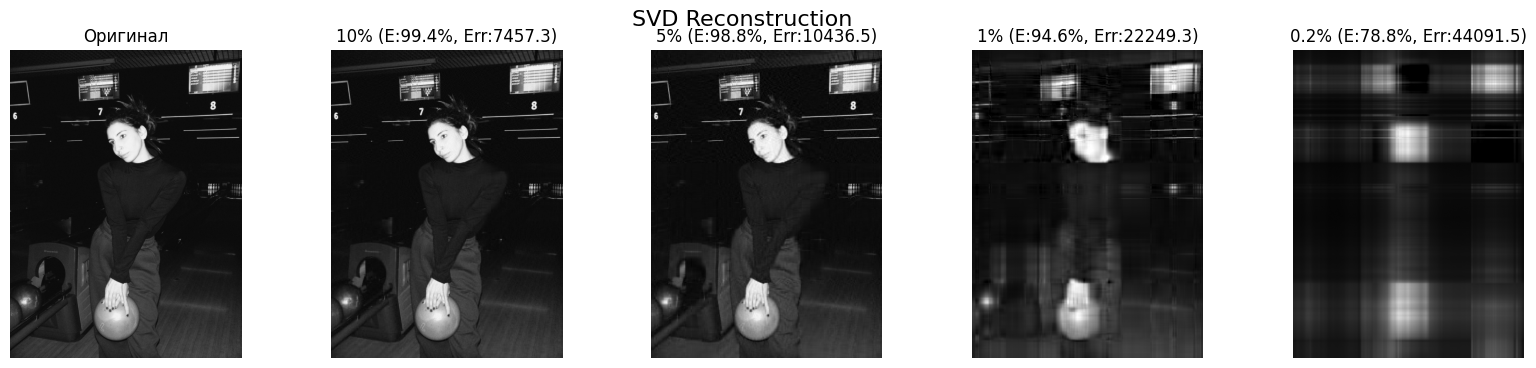

--- Method: FFT (ПОРТРЕТ) ---


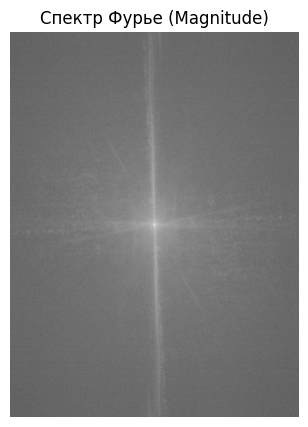

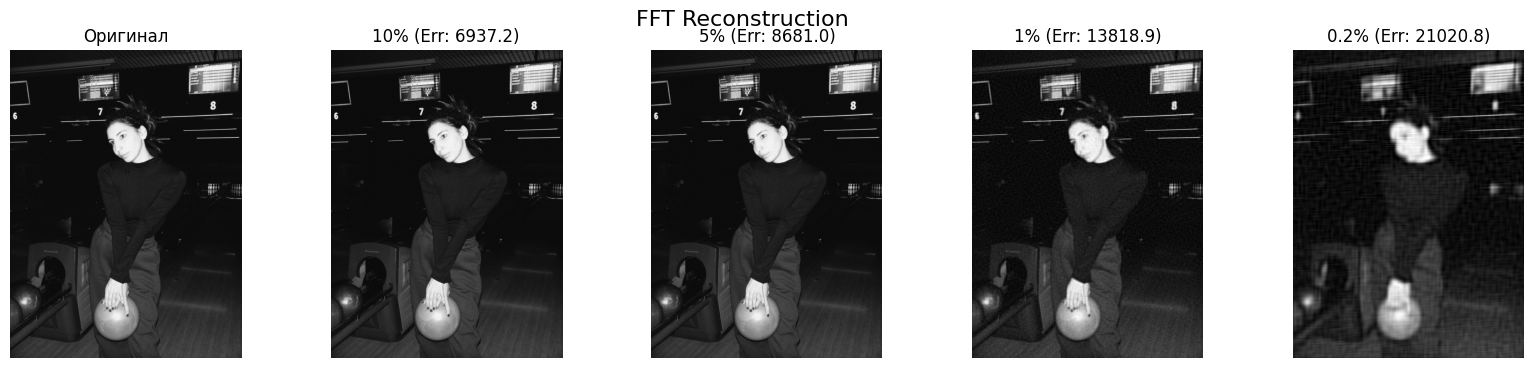

--- Method: Wavelet (ПОРТРЕТ) ---


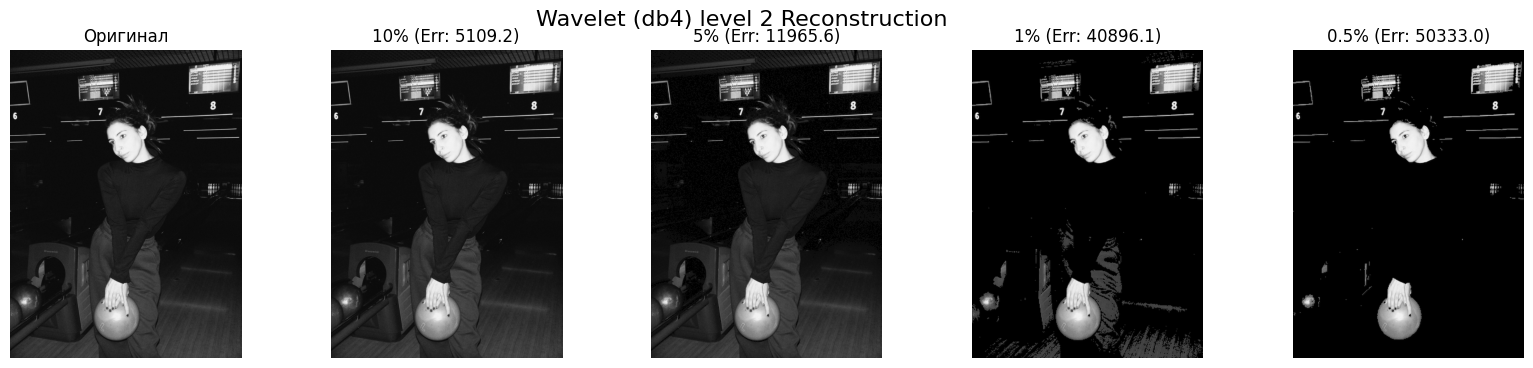

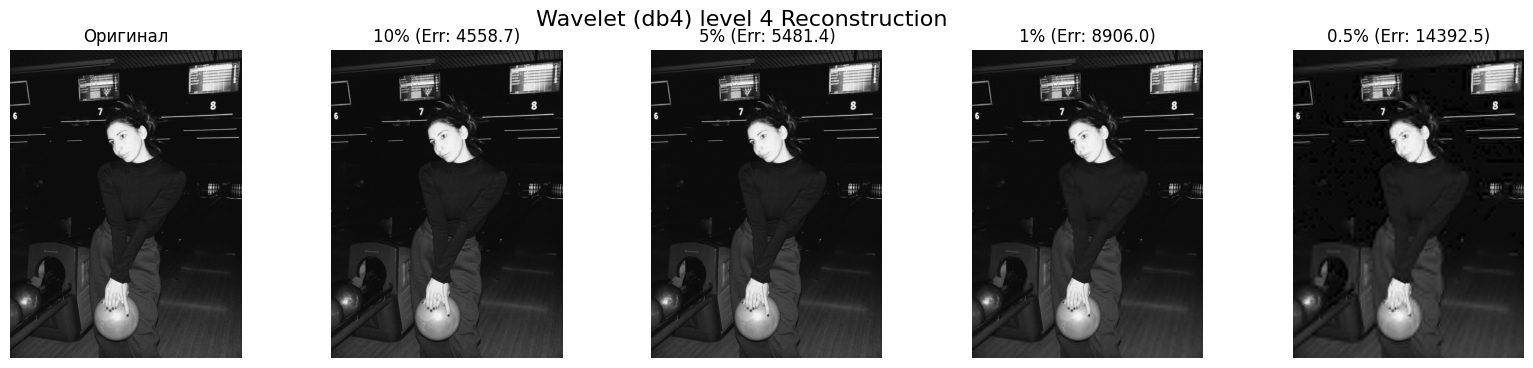

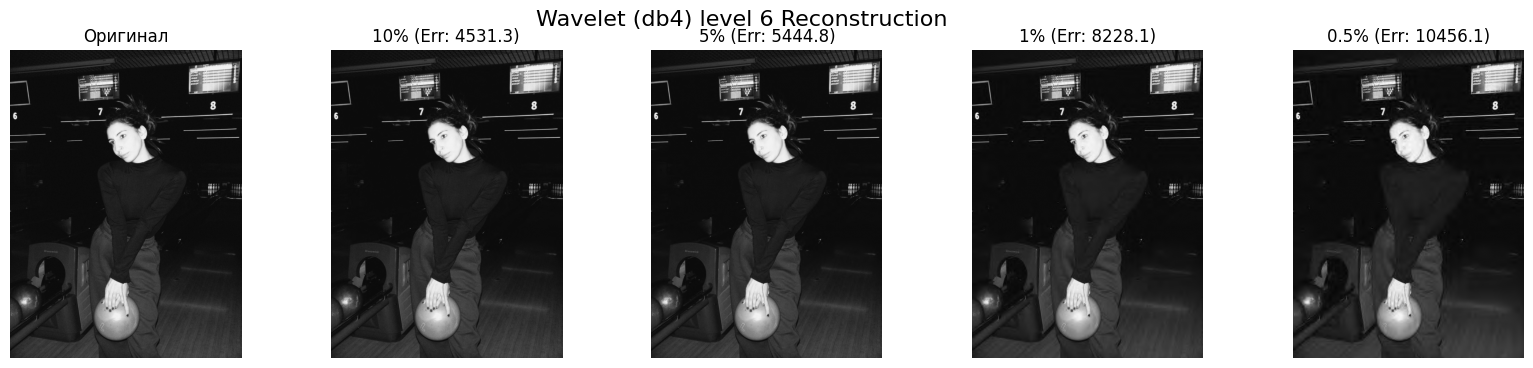


==================== УЛИЦА ====================


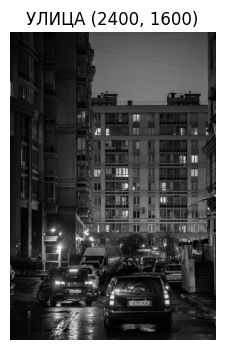

--- Method: SVD (УЛИЦА) ---


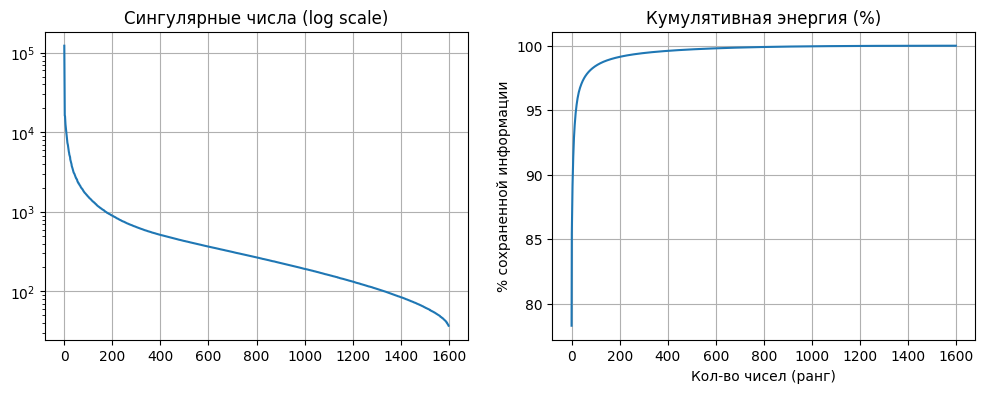

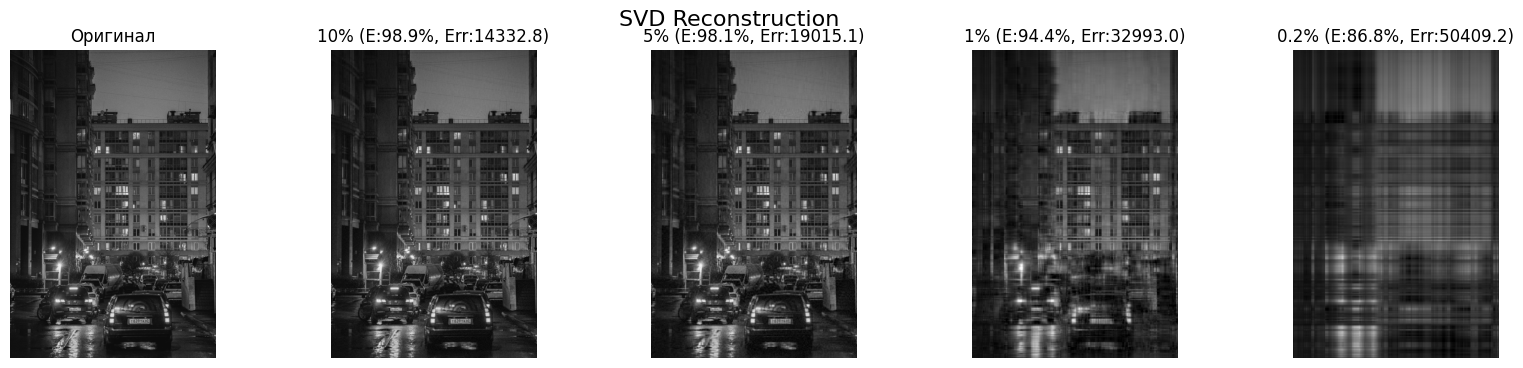

--- Method: FFT (УЛИЦА) ---


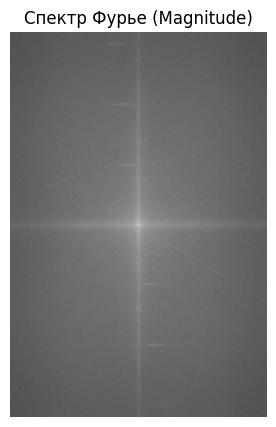

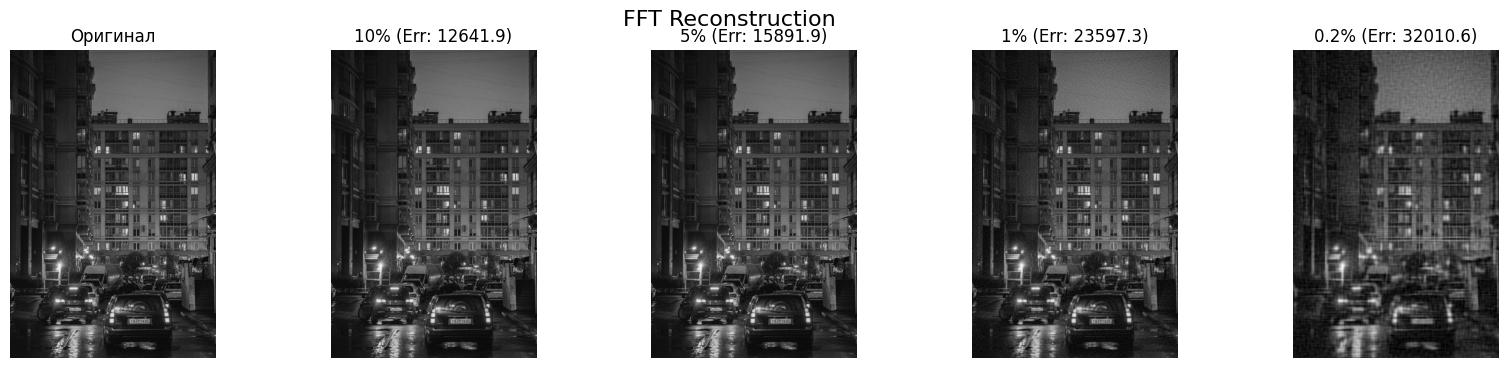

--- Method: Wavelet (УЛИЦА) ---


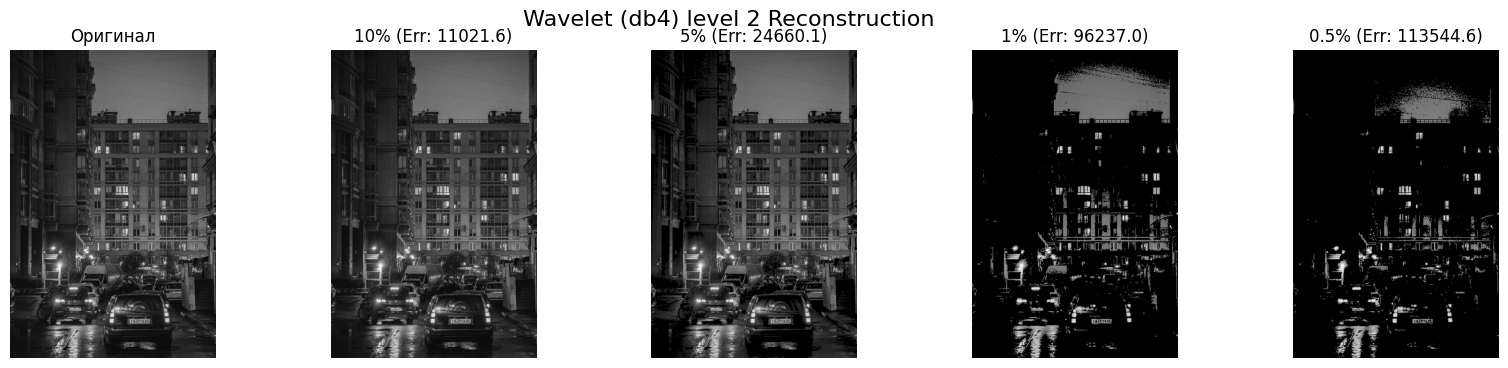

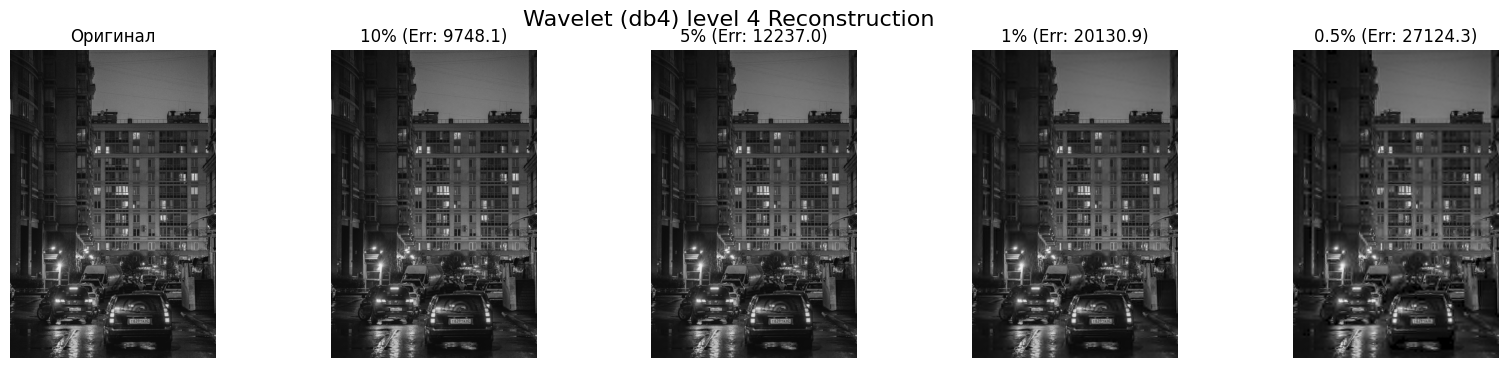

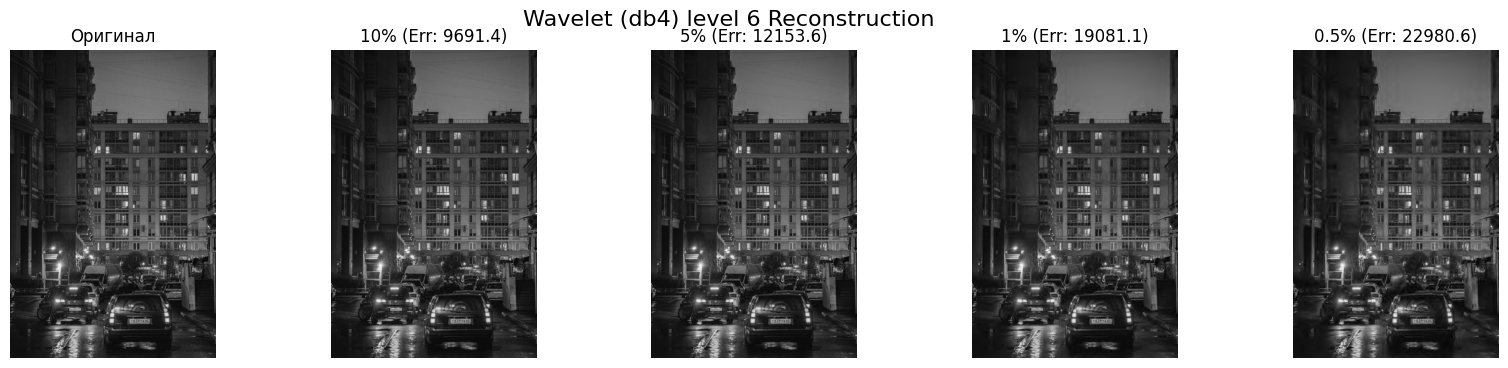


==================== ПРИРОДА ====================


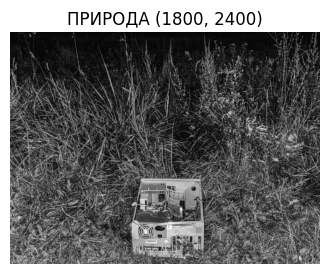

--- Method: SVD (ПРИРОДА) ---


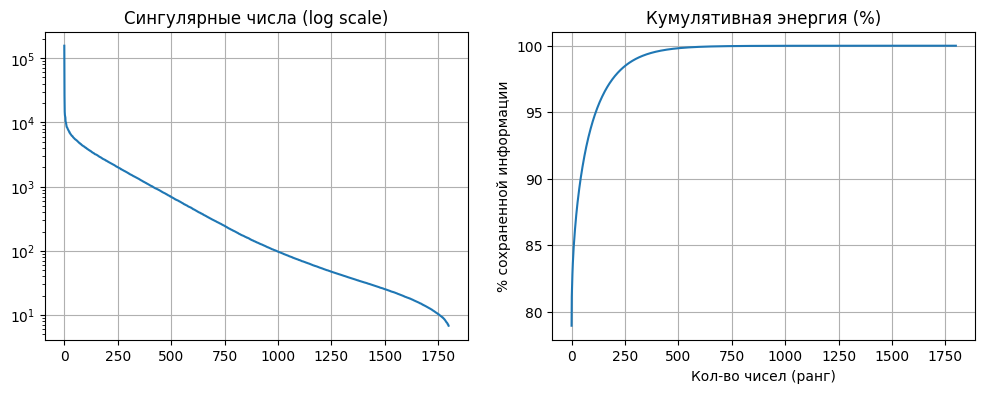

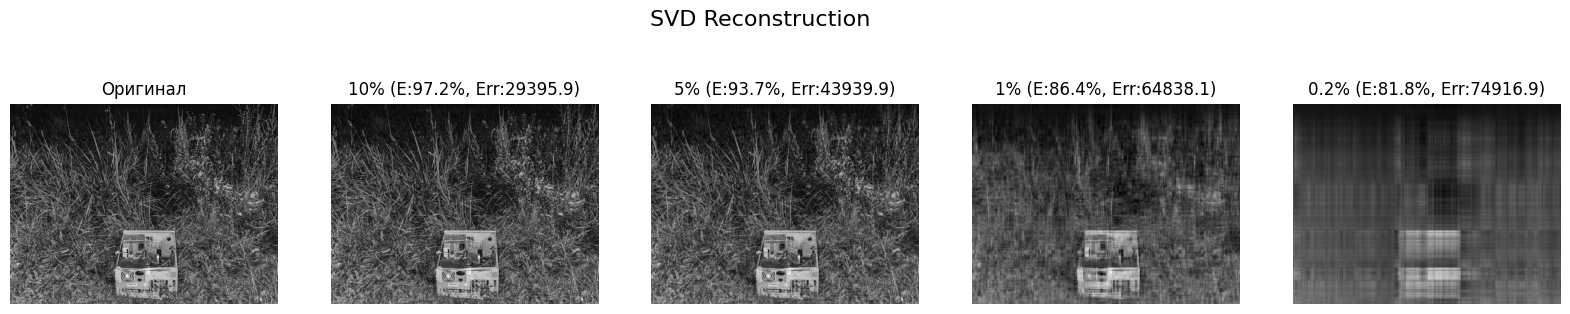

--- Method: FFT (ПРИРОДА) ---


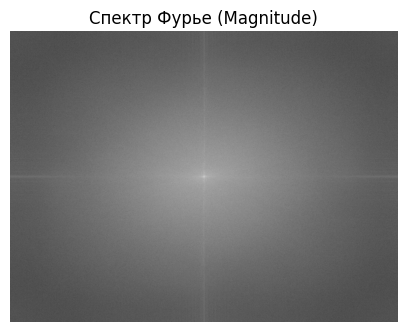

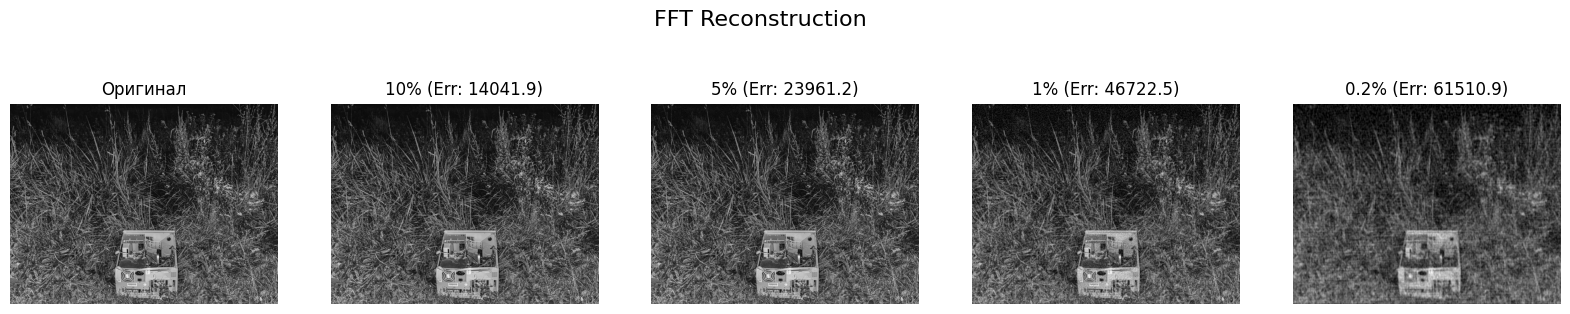

--- Method: Wavelet (ПРИРОДА) ---


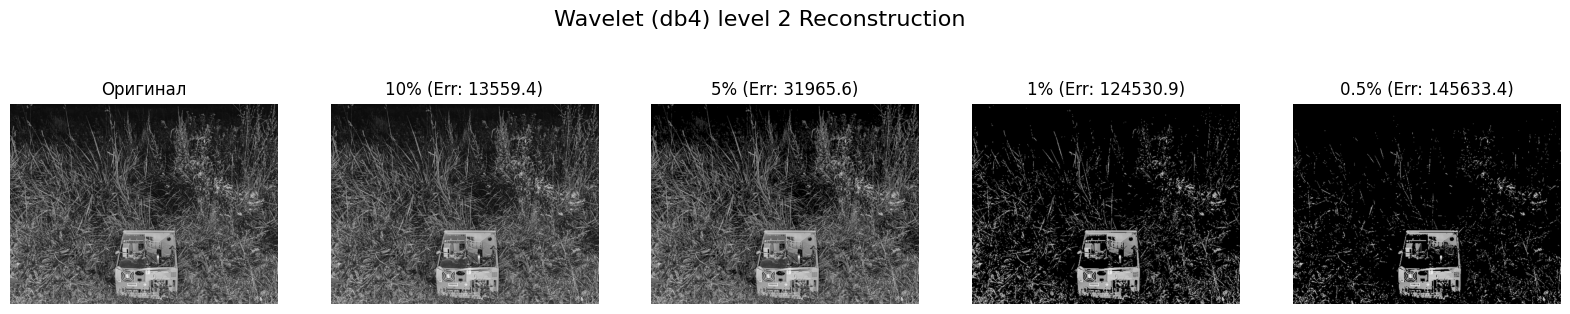

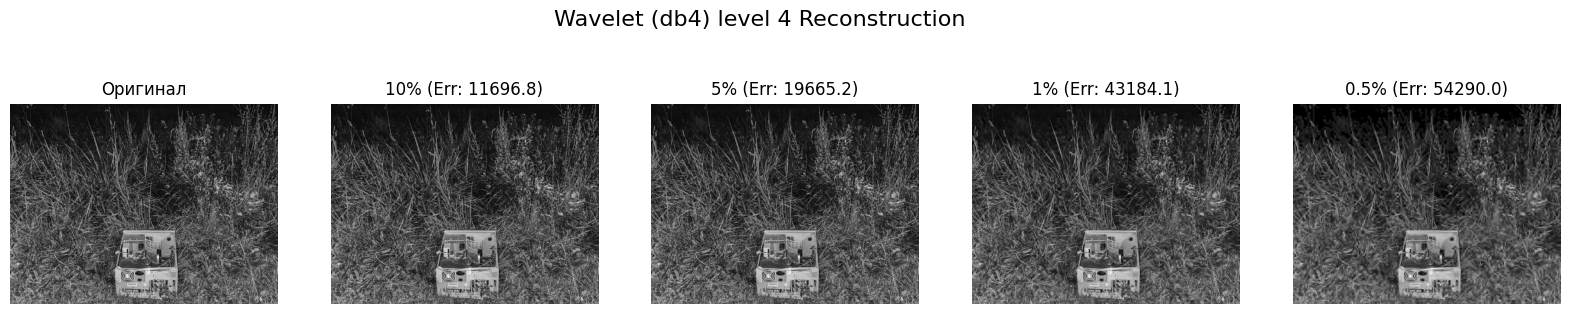

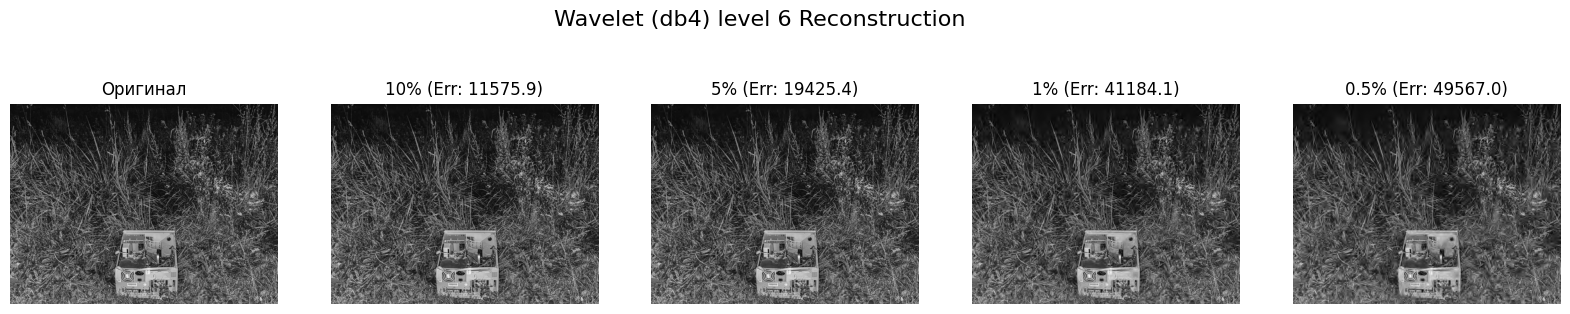

In [55]:
# Определяем изображения
tasks = [
    ("ПОРТРЕТ", "./data/face2.jpg"),
    ("УЛИЦА", "./data/street.jpg"),
    ("ПРИРОДА", "./data/nature.jpg")
]

percentages_svd_fft = [10, 5, 1, 0.2]  # % сохраняемых данных для SVD и FFT
percentages_wavelet = [10, 5, 1, 0.5]  # % сохраняемых данных для вейвлета

for name, source in tasks:
    print("\n" + "=" * 20 + " " + name + " " + "=" * 20)
    img = load_image(source)

    # Показываем исходник
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"{name} {img.shape}")
    plt.axis('off')
    plt.show()

    # Запускаем методы
    print(f"--- Method: SVD ({name}) ---")
    analyze_svd(img, percentages_svd_fft)

    print(f"--- Method: FFT ({name}) ---")
    analyze_fft(img, percentages_svd_fft)

    print(f"--- Method: Wavelet ({name}) ---")
    analyze_wavelet(img, percentages_wavelet, levels=[2, 4, 6])


### Выводы

1.  **SVD**: Обычно показывает лучшие результаты для изображений с четкой структурой и выравниванием (например, портреты). Однако, при очень сильном сжатии (0.2%) теряет детали быстрее вейвлетов.
2.  **FFT**: При сильном сжатии дает характерные артефакты ("волны" или "звон") вокруг границ объектов. Хорошо работает для периодических текстур.
3.  **Wavelet**: Обеспечивает наилучший визуальный баланс при сильном сжатии, так как не размывает границы объектов так сильно, как FFT, и не теряет локальные детали так, как SVD.

| Изображение | Высокие частоты | Сжатие FFT | Сжатие SVD | Сжатие Wavelet | Особенности спектра |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Портрет** | мало | отличное | отличное | отличное (почти как SVD) | сильный яркий центр, мало деталей |
| **Улица** | средне | средне | хорошо | хорошее/среднее | направленные полосы, структуры зданий |
| **Природа** | много | плохо | средне | лучшее, чем FFT и SVD | множество хаотичных высоких частот |
